<h1>Procesamiento de datos a gran escala</h1>

<p><strong>Objetivo: </strong> El objetivo de este cuaderno es aplicar el algoritmo de clustering a un conjunto de datos sencillos. </p>

<h2>Clustering</h2>

<h2>Indice</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ul>
  <li>Cargar los Datos</li>
  <li>Aplicando Algortimo K-Medias</li>
</ul>

Tiempo estimado: <strong>10 min</strong>

</div>
<hr>

<h3>Cargar los datos</h3>

Para este ejercicio se estará utilizando el conjunto de datos Iris, la cual es una fuente en línea en formato CSV (valores separados por coma).
<p> Este set de datos posee diferentes medidas sobre la planta Iris y es famosamente utilizado como ejemplo en analítica de datos:
  </p>
Se utiliza este conjunto para ejemplificar la creación de clusters:

<ul>
  <li>descripción: <a href="https://archive.ics.uci.edu/ml/datasets/Iris" target="_blank">https://archive.ics.uci.edu/ml/datasets/Iris</a></li>
  <li>fuente de datos: <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data" target="_blank">https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data</a></li>
    <li>tipo de datos: csv</li>

Se va a utilizar la librería Pandas de Python para realizar la lectura de archivos. Se cargan los datos, se agregan cabeceras y se muestra el resultado:

In [1]:
#!pip install findspark
#!pip install pyspark

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import findspark
findspark.init()
from pyspark import SparkConf
from pyspark.sql import SparkSession, SQLContext

import sys

In [4]:
# Configuración local
configuraDierickBrochero = (
    SparkConf()
        .set("spark.scheduler.mode", "FAIR")
        .set("spark.executor.memory", "10G")
        .set("spark.executor.cores", "1")
        .set("spark.cores.max", "9")
        .set("spark.ui.port", "4040")
        .setMaster("local[*]")  # <---- Spark local usando todos los cores
        .setAppName("hpcsparkDierickBrochero")
)

# Crear sesión Spark local
sparkDierickBrochero = (
    SparkSession
        .builder
        .config(conf=configuraDierickBrochero)
        .getOrCreate()
)

sqlContext = SQLContext(sparkDierickBrochero.sparkContext)

sparkDierickBrochero

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/19 22:28:01 WARN Utils: Your hostname, MacBook-Pro-de-Dierick.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.2 instead (on interface en0)
25/11/19 22:28:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/19 22:28:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Leer datos desde archivo CSV
import wget
from pyspark.sql.types import StructType, StructField, FloatType, StringType

url_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
local_path ="/Users/dierickbr/Library/CloudStorage/OneDrive-PontificiaUniversidadJaveriana/Computacion Alto desempeño/Datos"
wget.download(url_path,local_path)

schema = StructType([StructField("sepal_length", FloatType(), True),
                     StructField("sepal_width",  FloatType(), True),
                     StructField("petal_length", FloatType(), True),
                     StructField("petal_width",  FloatType(), True),
                     StructField("Species",        StringType(), True)])


df00 = sparkDierickBrochero.read.format("csv").option("header", "false").schema(schema).load(local_path)

df00.show(5)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows


In [6]:
df00.printSchema()

root
 |-- sepal_length: float (nullable = true)
 |-- sepal_width: float (nullable = true)
 |-- petal_length: float (nullable = true)
 |-- petal_width: float (nullable = true)
 |-- Species: string (nullable = true)



In [7]:
from pyspark.sql.functions import col, count, when, isnan

#df00.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

numeric_cols = [c for c, t in df00.dtypes if t in ('float', 'double')]
all_cols = df00.columns

exprs = [
    count(when(col(c).isNull() | (isnan(c) if c in numeric_cols else False), c)).alias(c)
    for c in all_cols
]

df00.select(exprs).show()

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|Species|
+------------+-----------+------------+-----------+-------+
|           0|          0|           0|          0|      0|
+------------+-----------+------------+-----------+-------+




### Aplicar Indexador a Columna "Species"

In [8]:
from pyspark.ml.feature import StringIndexer
# StringIndexer Initialization
indexer = StringIndexer(inputCol="Species", outputCol="Species_Indexed")
indexerModel = indexer.fit(df00)

# Transform the DataFrame using the fitted StringIndexer model
df01 = indexerModel.transform(df00)
df01.show()

+------------+-----------+------------+-----------+-----------+---------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|Species_Indexed|
+------------+-----------+------------+-----------+-----------+---------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|            0.0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|            0.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|            0.0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|            0.0|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|            0.0|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|            0.0|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|            0.0|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.1|         1.5| 

In [9]:
df01.select('Species').distinct().collect()

[Row(Species='Iris-virginica'),
 Row(Species='Iris-setosa'),
 Row(Species='Iris-versicolor')]

<h3>Aplicar Algortimo K-Medias</h3>

Seleccione solo las columnas numéricas:

In [10]:
df02 = df00[["sepal_length","sepal_width","petal_length","petal_width"]]
df02.show(5)

+------------+-----------+------------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|
+------------+-----------+------------+-----------+
|         5.1|        3.5|         1.4|        0.2|
|         4.9|        3.0|         1.4|        0.2|
|         4.7|        3.2|         1.3|        0.2|
|         4.6|        3.1|         1.5|        0.2|
|         5.0|        3.6|         1.4|        0.2|
+------------+-----------+------------+-----------+
only showing top 5 rows


### Formatear los datos usando Vector Assembler en los vectores los cuales serán usados como "features"

In [11]:
from pyspark.ml.feature import VectorAssembler

In [12]:
assembler = VectorAssembler(inputCols = df02.columns, outputCol='features')
df_datos = assembler.transform(df00)


### Escalar los datos

In [13]:
from pyspark.ml.feature import StandardScaler

escalador = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

In [14]:
# Compute summary statistics by fitting the StandardScaler
modeloEscalado = escalador.fit(df_datos)

# Normalize each feature to have unit standard deviation.
df_datos = modeloEscalado.transform(df_datos)

df_datos.show(5)

+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|            features|      scaledFeatures|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.09999990463256...|[-0.8991789060725...|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.90000009536743...|[-1.1411101906136...|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.69999980926513...|[-1.3830420519644...|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.59999990463256...|[-1.5040076942349...|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|[5.0,3.5999999046...|[-1.0201445483430...|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
only showing top 5 rows


### Encontrar el número de clusters usando Silhouette Score

In [15]:
#Importing the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]

evaluador = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures', \
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')

for i in range(2,10):
    kmeans=KMeans(featuresCol='scaledFeatures', k=i)
    KMeans_fit=kmeans.fit(df_datos)
    output = KMeans_fit.transform(df_datos)   
    score = evaluador.evaluate(output)   
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

25/11/19 22:28:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Silhouette Score for k = 2 is 0.7727933596456382
Silhouette Score for k = 3 is 0.6523362286529399
Silhouette Score for k = 4 is 0.5881491036454324
Silhouette Score for k = 5 is 0.5196334188468825
Silhouette Score for k = 6 is 0.5152584828519166
Silhouette Score for k = 7 is 0.5494292557845311
Silhouette Score for k = 8 is 0.5894705663847473
Silhouette Score for k = 9 is 0.5551661040294326


### Visualización de silhouette scores

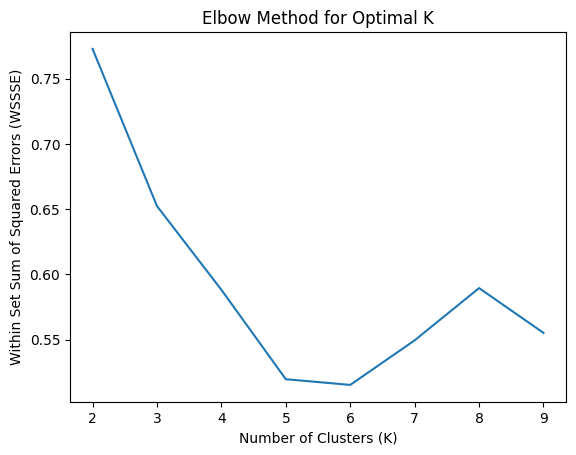

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(2,10),silhouette_score)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.show()

¿Cúal k seleccionar? ¿Son satisfactorios los resultados de las diferentes k? 
- Se selecciona k=3 (¿porqué?)
- Compare los resultados para k=4, k=6, k=8

### Entrenar el modelo

In [17]:
kmeans = KMeans(k=4, featuresCol="scaledFeatures", predictionCol="cluster")
kmeans_model = kmeans.fit(df_datos)

### Evaluar el modelo k=3 Within Set Sum of Squared Errors (WSSSE) metric

In [18]:
output = KMeans_fit.transform(df_datos)
wssse = evaluador.evaluate(output)
print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

Within Set Sum of Squared Errors (WSSSE) = 0.5551661040294326


### Visualizar los Datos

In [19]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler

k_kmeans = 3
seed_value = 42

# VectorAssembler: combinar columnas numéricas
numeric_cols = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_datos = assembler.transform(df00)

# Escalar características
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(df_datos)
df_datos = scaler_model.transform(df_datos)

# Crear y entrenar KMeans
kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="cluster", k=k_kmeans, seed=seed_value)
modelo_kmeans = kmeans.fit(df_datos)
clustered_data = modelo_kmeans.transform(df_datos) 

# Convertir a Pandas para visualización
clustered_data_pd = clustered_data.toPandas()


In [20]:
# Convertir PySpark DataFrame a Pandas
clustered_data_pd = clustered_data.toPandas()

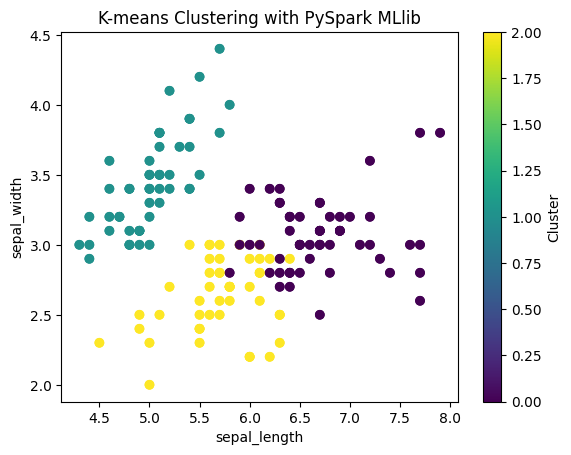

In [21]:
# Visualizing the results
plt.scatter(clustered_data_pd["sepal_length"], clustered_data_pd["sepal_width"], c=clustered_data_pd["cluster"], cmap='viridis')
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

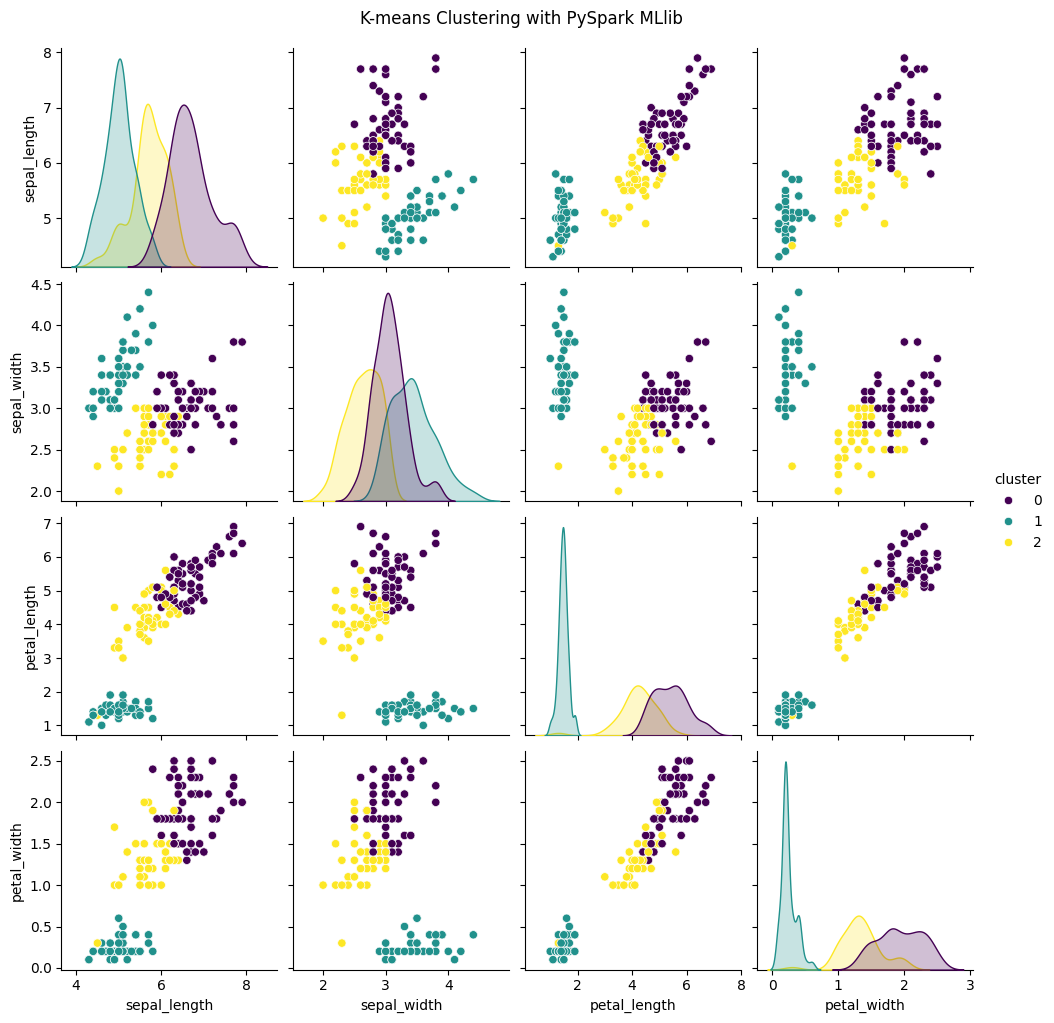

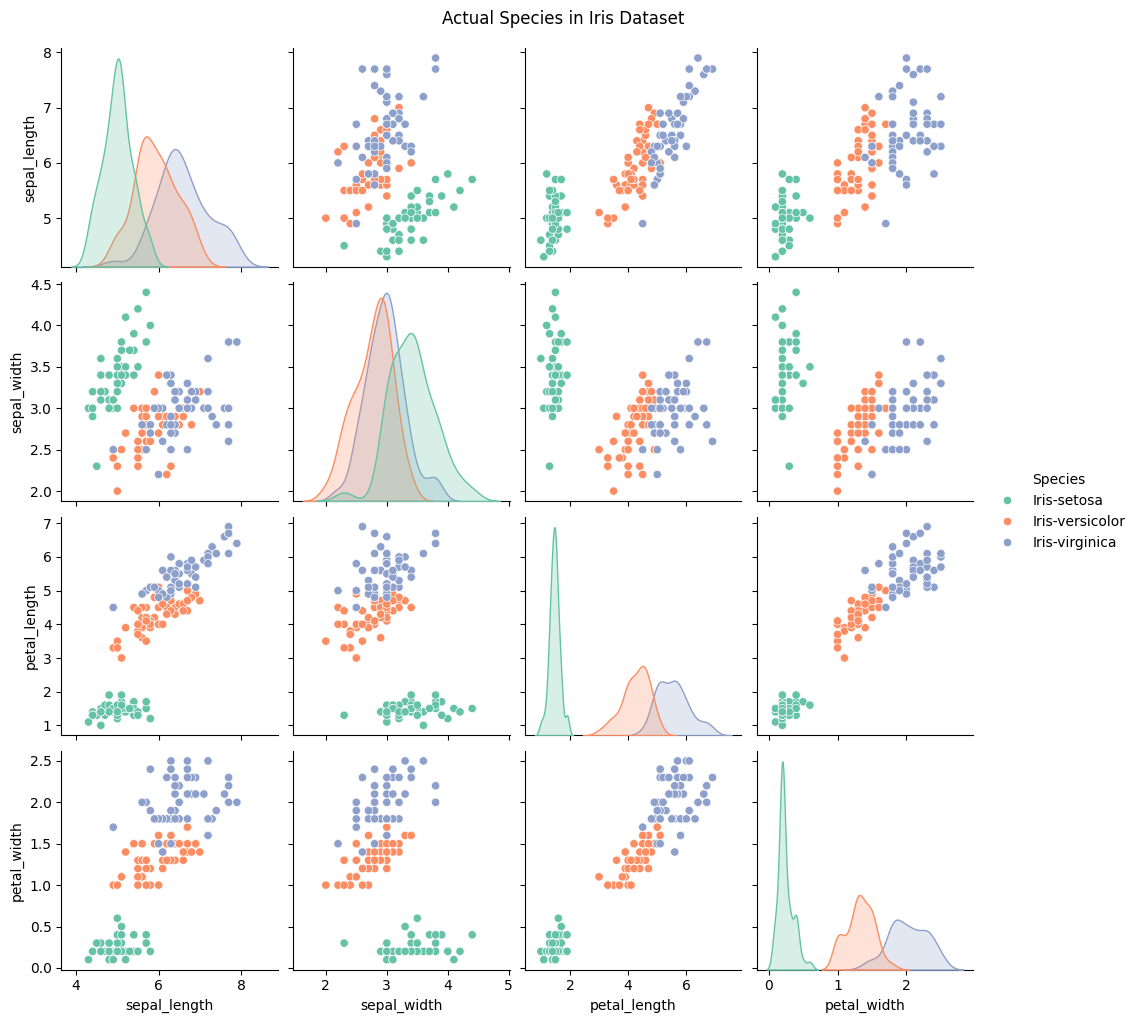

In [22]:
# Importar Seaborn y matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot para todas las columnas numéricas
sns.pairplot(
    clustered_data_pd, 
    hue='cluster',                # colorea por cluster
    vars=["sepal_length","sepal_width","petal_length","petal_width"],
    palette="viridis",
    diag_kind="kde"               # histogramas en diagonal
)
plt.suptitle("K-means Clustering with PySpark MLlib", y=1.02)
plt.show()

# Comparación con la especie real
sns.pairplot(
    clustered_data_pd, 
    hue='Species',                # colorea por especie real
    vars=["sepal_length","sepal_width","petal_length","petal_width"],
    palette="Set2",
    diag_kind="kde"
)
plt.suptitle("Actual Species in Iris Dataset", y=1.02)
plt.show()


In [23]:
df_datos.columns

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'Species',
 'features',
 'scaledFeatures']

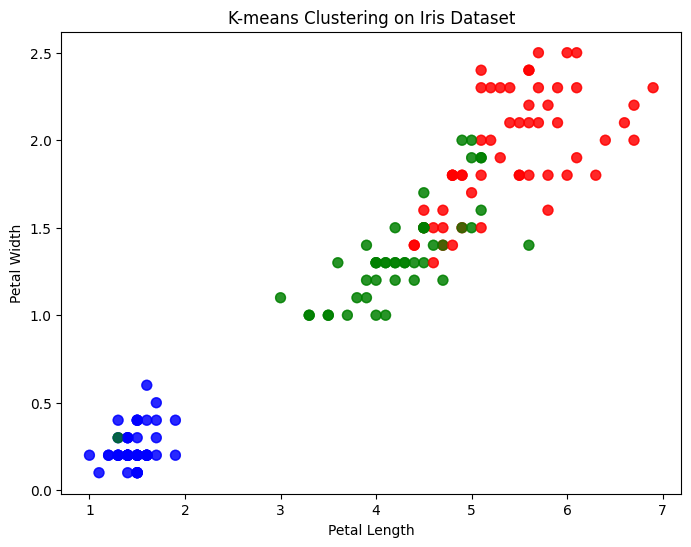

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Convertir a Pandas
clustered_data_pd = clustered_data.toPandas()

# Definir colores según el cluster (3 clusters en Iris)
colors = np.array(['red','blue','green'])

plt.figure(figsize=(8,6))
plt.scatter(
    x=clustered_data_pd["petal_length"],
    y=clustered_data_pd["petal_width"],
    c=colors[clustered_data_pd["cluster"]],  # mapea cada cluster a un color
    s=50,
    alpha=0.6
)
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.title("K-means Clustering on Iris Dataset")
plt.show()


Text(0.5, 1.0, 'Conjunto Iris')

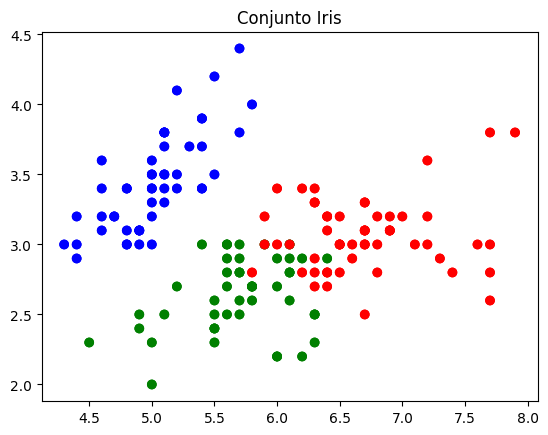

In [25]:
#Visualizando con Matplotlib
color =np.array(['red','blue','green','cyan','yellow'])
scatter = plt.scatter(
    x=clustered_data_pd.sepal_length,
    y=clustered_data_pd.sepal_width,
    c=colors[clustered_data_pd["cluster"]]
)
plt.title("Conjunto Iris")

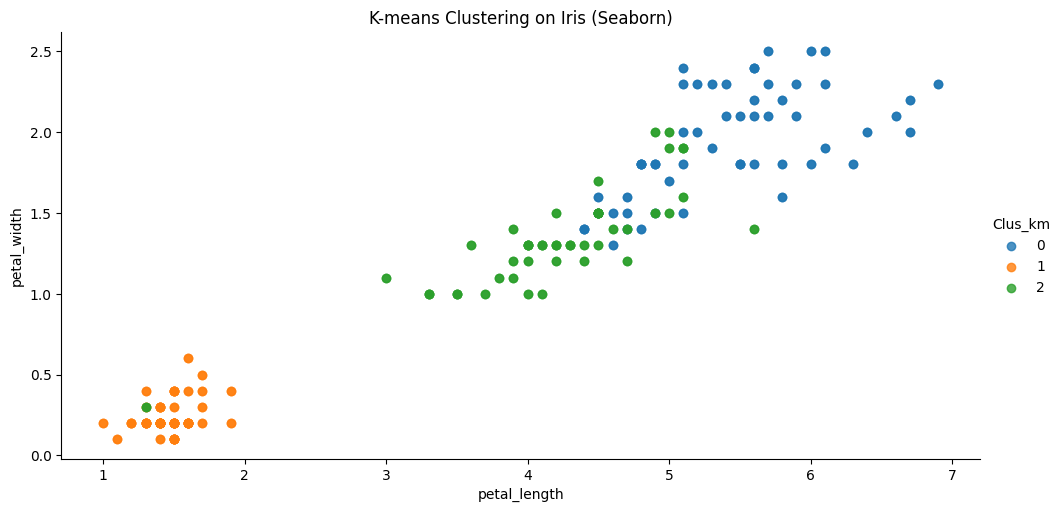

In [26]:
import seaborn as sns

# Asegúrate de que la columna de cluster se llame algo coherente
clustered_data_pd['Clus_km'] = clustered_data_pd['cluster']

# Visualización
sns.lmplot(
    x='petal_length',
    y='petal_width',
    data=clustered_data_pd,
    hue='Clus_km',       # color según cluster
    fit_reg=False,       # no dibuja regresión
    height=5,
    aspect=2
)

plt.title("K-means Clustering on Iris (Seaborn)")
plt.show()


In [27]:
sparkDierickBrochero.stop()